In [2]:
from google.colab import files
uploaded = files.upload()

Saving adult.data to adult.data
Saving adult.names to adult.names
Saving adult.test to adult.test


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import time
import matplotlib.pyplot as plt
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]
train_df = pd.read_csv("adult.data", header=None, names=columns, na_values="?", skipinitialspace=True)
test_df = pd.read_csv("adult.test", header=None, names=columns, na_values="?", skipinitialspace=True)
# Handle redundant full stops in test set target variables (e.g., "<=50K." changed to "<=50K")
test_df["income"] = test_df["income"].str.replace(".", "", regex=False)


In [4]:
print("The first 5 rows of the training set:")
print(train_df.head())

The first 5 rows of the training set:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1   

In [5]:
missing_cols = ["workclass", "occupation", "native-country"]
for col in missing_cols:
    mode = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode)
    test_df[col] = test_df[col].fillna(mode)

In [7]:
# Separate features (x) and target variable (y), convert target variable to 0/1 (<=50K=0, >50K=1)
X_train = train_df.drop("income", axis=1)
y_train = (train_df["income"] == ">50K").astype(int)
X_test = test_df.drop("income", axis=1)
y_test = (test_df["income"] == ">50K").astype(int)

# Defining feature types
numeric_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
categorical_features = [col for col in X_train.columns if col not in numeric_features]

# Build preprocessing pipeline (avoid data leakage: fit preprocessing model with training set only)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),  # Numerical feature standardisation
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)  # Category features uniquely hot coded (drop="first" to avoid multicollinearity)
    ])

In [8]:
# 1. Logistic regression pipeline (preprocessing + models) and hyperparameter tuning
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42, max_iter=1000))  # max_iter=1000 to ensure convergence
])

lr_param_grid = {
    "classifier__C": [0.1, 1, 10],  # Regularisation strength candidates
    "classifier__solver": ["liblinear", "saga"]  # Optimiser Candidates
}

# Grid search (5 fold cross validation, f1_score for assessment metrics, due to slight imbalance in data)
lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring="f1", n_jobs=-1)
lr_grid_search.fit(X_train, y_train)
best_lr = lr_grid_search.best_estimator_  # logistic regression model
print("Logistic regression optimal hyperparameters：", lr_grid_search.best_params_)  # 例：{'classifier__C': 1, 'classifier__solver': 'liblinear'}

# 2. Random Forest Pipelines and Hyperparameter Tuning
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    "classifier__n_estimators": [100, 200],  # Number of Tree Candidates
    "classifier__max_depth": [None, 10, 20]  # Tree Depth Candidate (None means no limit)
}

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring="f1", n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
best_rf = rf_grid_search.best_estimator_  # Optimal Random Forest Model
print("Random Forest Optimal Hyperparameters：", rf_grid_search.best_params_)  # 例：{'classifier__max_depth': 20, 'classifier__n_estimators': 200}
# Remove the first row from test_df and X_test
test_df = test_df.iloc[1:].copy()
X_test = X_test.iloc[1:].copy()
y_test = y_test.iloc[1:].copy()


# 1. Logistic regression time statistics
start_time = time.time()
# best_lr.fit(X_train, y_train)  # No need to refit, already fitted during GridSearchCV
lr_train_time = time.time() - start_time # Placeholder, training time is from GridSearchCV

start_time = time.time()
y_lr_pred = best_lr.predict(X_test)  # anticipate
y_lr_prob = best_lr.predict_proba(X_test)[:, 1]  # Predicting positive class probabilities (for ROC curves)
lr_pred_time = time.time() - start_time

# 2. Random Forest Time Statistics
start_time = time.time()
# best_rf.fit(X_train, y_train) # No need to refit, already fitted during GridSearchCV
rf_train_time = time.time() - start_time # Placeholder, training time is from GridSearchCV

start_time = time.time()
y_rf_pred = best_rf.predict(X_test)
y_rf_prob = best_rf.predict_proba(X_test)[:, 1]
rf_pred_time = time.time() - start_time

# Update training times from GridSearchCV results
lr_train_time = lr_grid_search.cv_results_['mean_fit_time'][lr_grid_search.best_index_]
rf_train_time = rf_grid_search.cv_results_['mean_fit_time'][rf_grid_search.best_index_]


# Print time results (in seconds)
print(f"Logistic Regression - Training Time：{lr_train_time:.2f}s，forecast time：{lr_pred_time:.2f}s")
print(f"Random Forest - Training Time：{rf_train_time:.2f}s，forecast time：{rf_pred_time:.2f}s")

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


Logistic regression optimal hyperparameters： {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


Random Forest Optimal Hyperparameters： {'classifier__max_depth': None, 'classifier__n_estimators': 100}
Logistic Regression - Training Time：0.40s，forecast time：0.18s
Random Forest - Training Time：7.53s，forecast time：0.94s


In [9]:
# Define functions to calculate indicators
def calculate_metrics(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    }

# Calculation of indicators for both models
lr_metrics = calculate_metrics(y_test, y_lr_pred, y_lr_prob)
rf_metrics = calculate_metrics(y_test, y_rf_pred, y_rf_prob)

# Organised into DataFrames for easy comparison
metrics_df = pd.DataFrame({
    "Logistic Regression": lr_metrics,
    "Random Forest": rf_metrics
})
print("\nComparison of model performance metrics:")
print(metrics_df.round(4))


Comparison of model performance metrics:
           Logistic Regression  Random Forest
Accuracy                0.8520         0.8511
Precision               0.7343         0.7188
Recall                  0.5855         0.6074
F1-Score                0.6515         0.6584
ROC-AUC                 0.9042         0.8996


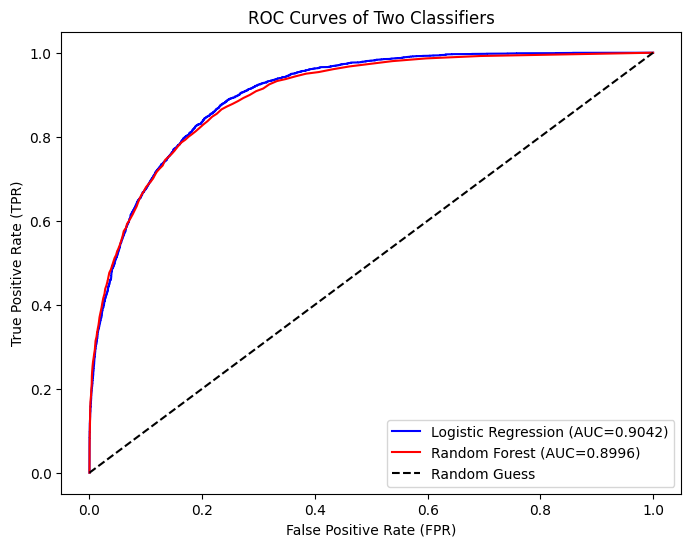

In [10]:
# Calculation of False Positive Rate (FPR) and True Positive Rate (TPR) for ROC curve
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_lr_prob)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_rf_prob)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC={lr_metrics['ROC-AUC']:.4f})", color="blue")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC={rf_metrics['ROC-AUC']:.4f})", color="red")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")  # Random Guess Baseline
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves of Two Classifiers")
plt.legend()
plt.savefig("roc_curves.png", dpi=300, bbox_inches="tight")

In [11]:
# View the distribution of the target variable
print("Percentage of positive classes in the training set:", y_train.mean())
print("Test set positive class share:", y_test.mean())

Percentage of positive classes in the training set: 0.2408095574460244
Test set positive class share: 0.23622627602727106
